# Threshold exploration

Here we will explore the effects of threshold in the multilayer free stimuli model. Three questions will be answered:
1. How many links do I have between layers
2. How many links do I have within layers
3. Are there any layers empty?

In [52]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pickle

sns.set_style("darkgrid")
sns.set_context("poster", font_scale = .6, rc={"grid.linewidth": 0.6})

## Read the data

We will use data already preprocessed and checked for quality control. In this dataset, we have 36 patients and 29 controls. We also have 14 ROIs that were chosen by psychiatrists. These include areas from default mode and salience networks. 

In [46]:
path = "/m/nbe/scratch/heps/trianaa1/multilayer/results/"
file = open(f'{path}/FC_jussi_corr','rb')
fc_file = pickle.load(file)
file = open(f'{path}/ISFC_jussi_corr','rb')
isfc_file = pickle.load(file)

In [47]:
#FC
fc = fc_file.flatten()

#ISC
isc = []
for key in isfc_file.keys():
    isc = np.append(isc, np.diagonal(isfc_file[key]))

#ISFC
isfc = []
isfc_isc = []
for key in isfc_file.keys():
    isfc = np.append(isfc,isfc_file[key][~np.eye(isfc_file[key].shape[0],dtype=bool)])
    isfc_isc = np.append(isfc_isc,isfc_file[key].flatten())

## Thresholded data
Since we are interested in the brute number, we have just prepared the links in a flatten format. Now, we will threhold the data and check the number of non-zero elements. Let's first check the number by model (functional connectivity (FC), intersubject connectivity (ISC), and intersubject functional connectivity (ISFC)).

### Per model
Here, we are combining three models that were developed separatedly, FC, ISC, and ISFC. 

It is good to remember that:
X = S + I + N, which means

bold signal = stimulus-induced signal + intrinsic-neural signal + non-neuronal signal, or alternatively,

bold signal = response to the stimuli + signal from other processes + signals like heart rate.

Since FC correlates signal within the same subject, and N signals are the same, then the correlation is higher. 


In [48]:
thr = np.linspace(0,1,21)
thresholded = np.zeros((3,21))
for i,t in enumerate(thr):
    thresholded[0,i] = len(fc[fc>t])
    thresholded[1,i] = len(isc[isc>t])
    thresholded[2,i] = len(isfc[isfc>t])

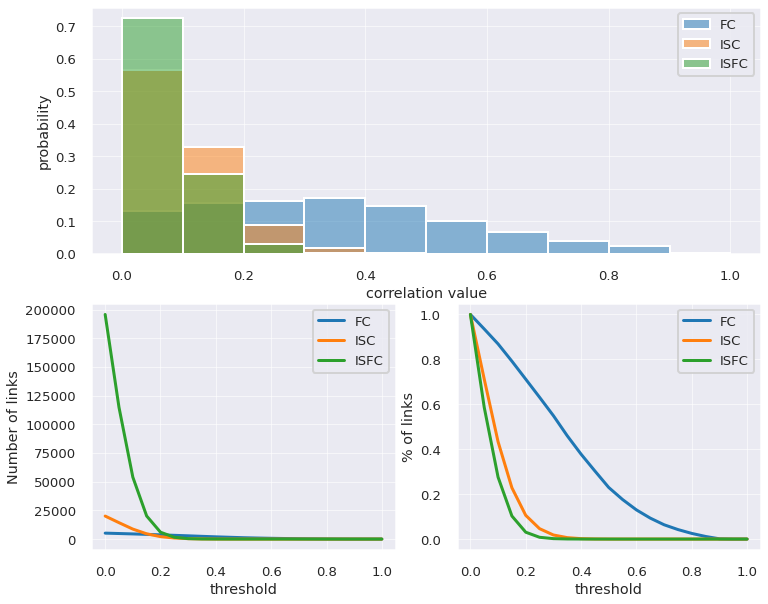

In [53]:
fig = plt.figure(figsize=(12,10))
gs = gridspec.GridSpec(2, 2)
ax0 = plt.subplot(gs[0,0:2])
ax1 = plt.subplot(gs[1,0])
ax2 = plt.subplot(gs[1,1])

fc_ax = sns.histplot(fc.flatten(), binwidth=0.1, binrange=(0,1), stat='probability', color='tab:blue', alpha=0.5, ax=ax0, label='FC')
isc_ax = sns.histplot(isc.flatten(), binwidth=0.1, binrange=(0,1), stat='probability', color='tab:orange', alpha=0.5, ax=ax0, label='ISC')
ax0 = sns.histplot(isfc.flatten(), binwidth=0.1, binrange=(0,1), stat='probability', color='tab:green', alpha=0.5, ax=ax0, label='ISFC')
ax0.set_xlabel('correlation value')
ax0.set_ylabel('probability')
ax0.legend()

fc_ax=sns.lineplot(x=thr, y=thresholded[0,:], color='tab:blue', ax=ax1, label="FC")
isc_ax=sns.lineplot(x=thr, y=thresholded[1,:], color='tab:orange', ax=ax1, label="ISC")
ax1 = sns.lineplot(x=thr, y=thresholded[2,:], color='tab:green', ax=ax1, label="ISFC")
ax1.set_xlabel("threshold")
ax1.set_ylabel("Number of links")
ax1.legend()

sns.lineplot(x=thr, y=thresholded[0,:]/thresholded[0,0], color='tab:blue', ax=ax2, label="FC")
sns.lineplot(x=thr, y=thresholded[1,:]/thresholded[1,0], color='tab:orange', ax=ax2, label="ISC")
ax2 = sns.lineplot(x=thr, y=thresholded[2,:]/thresholded[2,0], color='tab:green', ax=ax2, label="ISFC")
ax2.set_xlabel("threshold")
ax2.set_ylabel("% of links")
ax2.legend()

From the distributions, we see that the correlation values for FC is higher than the values for ISC and ISFC. This is expected as ISC and ISFC correlate areas between a pair of subjects, whereas FC correlates areas within a subject. Similarly, ISFC has slightly lower correlation values than ISC. 
From the line plots, we see that the number of ISFC links is larger than the FC and ISC links. This is also expected as ISFC correlates areas between subjects. Therefore, it is better to plot the proportion of the links that survive after applying the threshold. Here, we see the decline is faster for ISC and ISFC and that the threshold should not be larger than 0.3 for both techniques. On the other hand, we can have higher thresholds for FC. 

### Based on the multilayer model 1

Model 1 is the model where layers are subjects and nodes are ROIs. In this model, the intra-layer links are due to FC and the inter-layer links are due to ISC and ISFC. We choose this model first, because it is easier to justify the threshold numbers.

In [41]:
# Based on the model of layers=subjects, nodes=ROIs
n_sub = fc_file.shape[0]

intra_layer = np.zeros((n_sub,21))
for i,t in enumerate(thr):
    intra_layer[:,i] = (fc_file > t).sum(axis=1)

inter_layer = np.zeros((n_sub,21))
keys = list(isfc_file.keys())
for sub in range(n_sub):
    sub_isfc = []
    key_selection = [x for x in keys if x.startswith(f'{sub}-')] + [x for x in keys if x.endswith(f'-{sub}')]
    for key in key_selection:
        sub_isfc = np.append(sub_isfc,isfc_file[key].flatten())
        for i,t in enumerate(thr):
            inter_layer[sub,i] = (sub_isfc > t).sum()

Text(0.5, 1.0, 'inter-layer')

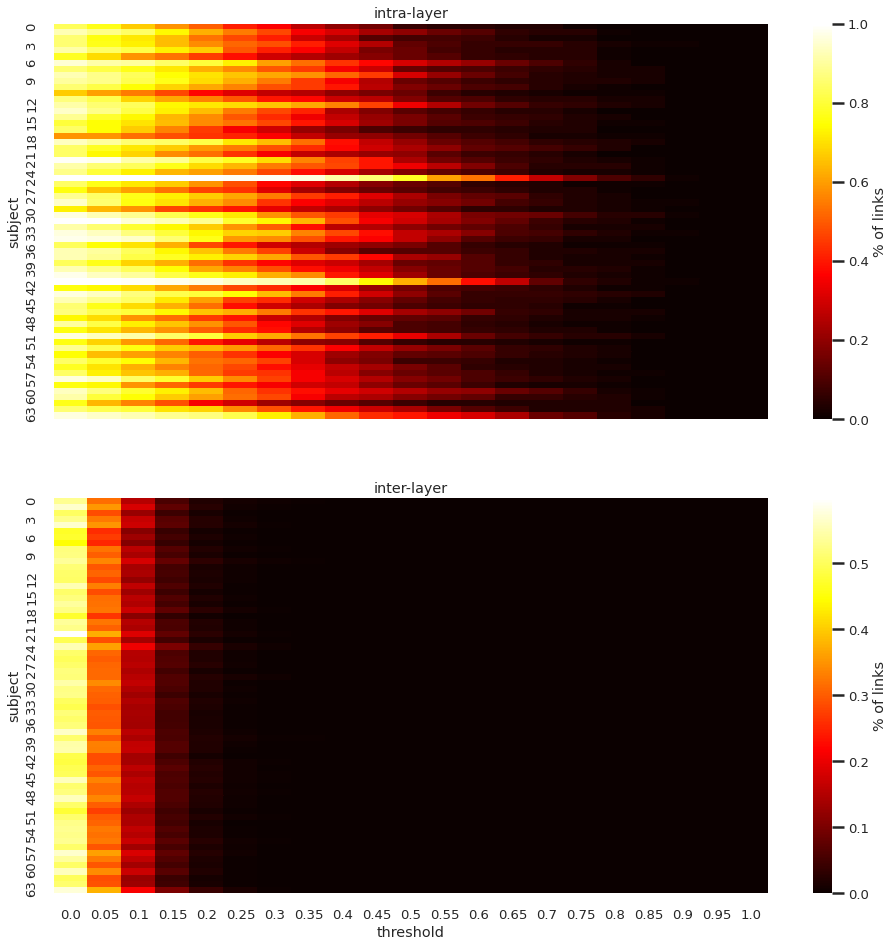

In [54]:
fig, (ax0, ax1) = plt.subplots(2, figsize=(16,16))
ax0 = sns.heatmap(intra_layer/91, vmin=0, cmap="hot", cbar=True, xticklabels=False, cbar_kws={'label': '% of links'}, ax=ax0)
ax0.set_ylabel('subject')
ax0.set_title('intra-layer')

ax1 = sns.heatmap(inter_layer/12740, vmin=0, cmap="hot", cbar=True, xticklabels=list(np.around(thr,2)), cbar_kws={'label': '% of links'}, ax=ax1)
ax1.set_xlabel('threshold')
ax1.set_ylabel('subject')
ax1.set_title('inter-layer')

Based on the heatmaps, the layers become sparsely connected from thresholds bigger than 0.45, i.e. the intra-layer links are scarse (FC). The first time a layer becomes non-connected is at thr=0.8.

In the inter-layer case, the layers become sparsely connected already at thr=0.2. The first time a layer is disconnected from others happens at thr=0.35

### Based on Multilayer model 2
Model 2 is the model where layers are ROIs and nodes are subjects. In this model, the intra-layer links are due to ISC, and the inter-layer links are due to FC and ISFC. Because of the difference in distributions from the histogram plot, applying one threshold to the inter-layer links will have two consequences:
1. if the threshold is too low, most links from FC will survive
2. if the threshold is too high, most links from ISFC will not survive

In either case, the network will be highly influenced by FC. Consequently, I would suggest we use model 1 for applying the threshold. Then, to analyze, we can easily switch to model 2 since the tuples are interchangeable in multilayer networks. 

## Conclusion

For a start, I would choose the intra-layer threshold to be FC_thr = 0.5, and the inter-layer threshold to be ISFC_thr = 0.1